## Example Usage for structpy.rc

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from structpy.rc import RcSection, conc_force, rebar_force
from IPython.display import display
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Section Properties

In [2]:
t_pad = 36      # Pad thickness (in)
w = 12          # Assumed section width = Rebar spacing
c_t = 2         # Concrete cover at the top (in)
c_b = 3         # Concrete cover at the bottom (in)
d_bar = 1.41    # Bar diameter (psi)
fc = 4000       # Concrete compressive strength (psi)
Es = 2.9*10**7 # Steel Young's modulus (psi)
sy = 60000      # Steel yield strength (psi)
e_fc = 0.003    # Concrete failure strain in compression

In [3]:
# Derived Quantities
p_t_bar = t_pad-c_t-1.5*d_bar   # Position of top rebar from the base of the section
p_b_bar = c_b+1.5*d_bar         # Position of bottom rebar from the base of the section
A_s = (np.pi/4) * d_bar**2      # Area of steel rebar

### Reinforced Concrete Section Analysis

Rebar added; pos = (0, 31.885), od = 1.41

Rebar added; pos = (0, 5.115), od = 1.41



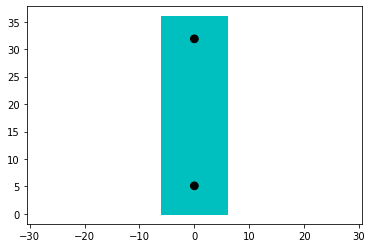

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [4]:
rc = RcSection(
    width=w, thk=t_pad, fc=fc, e_fc=e_fc, metric=False,
)
rc.add_rebar(D=d_bar, y=p_t_bar, sy=sy, Es=Es)
rc.add_rebar(D=d_bar, y=p_b_bar, sy=sy, Es=Es)
rc.plot_section()

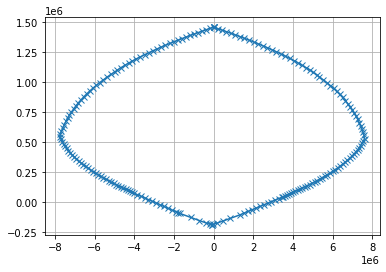

In [5]:
interaction = rc.generate_interaction_diagram(npts=100)
plt.grid()

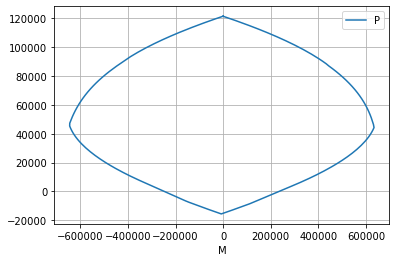

In [6]:
(interaction[['P', 'M']]/12).plot(x='M', y='P')
plt.grid()

In [7]:
(interaction[['P', 'M']]/12).describe()

,P,M
count,202.000000,202.000000
mean,48956.205693,-3723.403904
std,43318.263685,419600.817922
min,-15614.500887,-645086.653684
25%,10087.015793,-397517.179308
50%,40000.239841,-1478.626286
75%,90561.082236,386404.856191
max,121515.178283,634247.440441


In [8]:
interaction.loc[interaction['M'].abs().idxmax()]

,P,M,e_top,e_bot
48,492470.576474,7.492675e+06,0.003000,-0.003332
48,544621.409267,-7.741040e+06,-0.002819,0.003000


In [9]:
rc.beta_1

0.85

In [18]:
etop, ebot = -0.002654,	0.003000
conc_P, conc_cent = conc_force(rc.thk, rc.width,
                                       etop, ebot, rc.beta_1,
                                       **rc.conc_matprops)
display(conc_P/12)
display(conc_cent)

55203.395825963926

-9.881853555005305

In [11]:
rebar_P = rc.rebars.apply(
                rebar_force, axis=1, args=(rc.thk, etop, ebot),
                **rc.conc_matprops,
            )
rebar_P/12

0   -7576.126589
1    -442.410858
dtype: float64

In [12]:
display(interaction)
interaction[interaction['P'].abs()<10000]['M']/12

,P,M,e_top,e_bot
0,1.458182e+06,-5308.930301,0.003000,0.003000
1,1.458182e+06,-5308.930301,0.003000,0.000450
2,1.446166e+06,209203.472066,0.003000,0.000429
3,1.433756e+06,427048.845380,0.003000,0.000407
4,1.420947e+06,647936.681699,0.003000,0.000384
...,...,...,...,...
4,1.425887e+06,-573842.978798,0.000393,0.003000
3,1.437022e+06,-380707.622125,0.000413,0.003000
2,1.447785e+06,-191134.145146,0.000432,0.003000
1,1.458182e+06,-5308.930301,0.000450,0.003000


87    242444.553001
88    226987.051336
88   -242395.358858
87   -258491.558841
Name: M, dtype: float64

In [13]:
num = 100
top_strain_lims, bot_strain_lims = rc.get_strain_limits()
e_top_range = np.linspace(*top_strain_lims, num=num)
e_bot_range = np.linspace(*bot_strain_lims, num=num)

In [14]:
e_top_plot, e_bot_plot = np.meshgrid(e_top_range, e_bot_range)

In [15]:
P = np.reshape(
    [rc.get_P((x, y))/w for x, y in list(zip(e_top_plot.flatten(), e_bot_plot.flatten()))], 
    (num, num),
    )
M = np.reshape(
    [rc.get_M((x, y))/w for x, y in list(zip(e_top_plot.flatten(), e_bot_plot.flatten()))], 
    (num, num),
    )

(-0.0020689655172413794, 0.003)

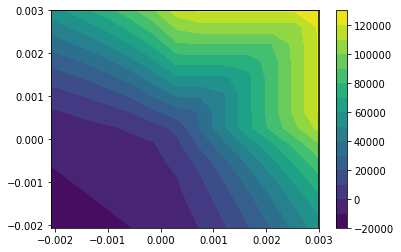

In [20]:
# Axial Force
plt.contourf(e_bot_plot, e_top_plot, P, levels=15)
plt.colorbar()
plt.plot(*interaction[['e_bot', 'e_top']].values.T, 'k')
plt.xlim((-sy/Es, e_fc))
plt.ylim((-sy/Es, e_fc))

(-0.0020689655172413794, 0.003)

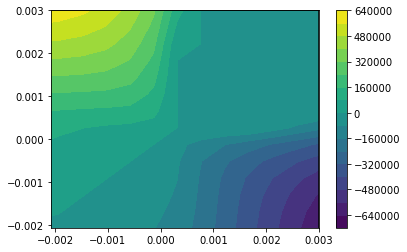

In [17]:
# Moment
plt.contourf(e_bot_plot, e_top_plot, M, levels=15)
plt.colorbar()
plt.plot(*interaction[['e_bot', 'e_top']].values.T, 'k')
plt.xlim((-sy/Es, e_fc))
plt.ylim((-sy/Es, e_fc))

In [ ]:
# P/M
plt.contourf(e_bot_plot, e_top_plot, M, levels=15)
plt.colorbar()
plt.plot(*interaction[['e_bot', 'e_top']].values.T, 'k')
plt.xlim((-sy/Es, e_fc))
plt.ylim((-sy/Es, e_fc))

In [ ]:
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
# ax.plot_surface(e_bot_plot, e_top_plot, M, color='b')
surf = ax.plot_surface(
    e_bot_plot, e_top_plot, P, rstride=1, cstride=1,
    facecolors=cm.jet(P),
    linewidth=0, antialiased=False, shade=False
    )